# Performing symbolic simulation in Tangelo

Tangelo has the capability of simulating a quantum circuit with symbolic simulation. The symbolic backend, based on [SymPy](https://www.sympy.org/en/index.html), could be a great educational tool and play an important role in quantum computing research workflows. We illustrate this statement on three use cases.

In [1]:
!pip install git+https://github.com/goodchemistryco/Tangelo.git@develop --quiet

The SymPy package is a python library for symbolic mathematics, able to perform algebraic operations on mathematical expressions. We show in this notebook some use cases where using symbolic simulation might be useful for quantum computing research purposes. But first, let us introduce how quantum computing experiments are modelled mathematically.

Linear algebra is an essential tool for predicting quantum experiment outcomes. In quantum computing, the computer state is described by quantum dits (qudits), i.e. the unit of quantum information described by a superposition of $d$ states. Customarily, quantum computing algorithms are constructed with quantum bits (qubits) in mind, that is to say the $d=2$ case. A many-qubit state can be represented by either a vector of size $2^n$ elements for a pure state, or a square matrix of size $2^n \times 2^n$ for a mixed state, where $n$ is the number of qubits. Quantum operations (gates) are represented by unitary matrices of consistent size. Time evolution of a state is modeled mathematically by matrix multiplication with a given set of unitaries, each representing quantum gates. One can empirically set a single qubit into a superposition of states described by

$$\alpha |0\rangle + \beta |1\rangle$$

where $\alpha, \beta \in \mathbb{C}$ and $\alpha^{\dagger}\alpha + \beta^{\dagger}\beta = 1$. Analyzing the effect of $\alpha$ and $\beta$ of this qubit state on an entangled many-qubit system can be a valuable asset for research, as illustrated by the examples featured in this notebook. Quantum mechanics state that the probabilites of getting each basis state after measurement are proportional to the amplitudes ($\alpha^{\dagger} \alpha$ (resp. $\beta^{\dagger} \beta$) for the $|0\rangle$ (resp. $|1\rangle$) state). The products of the coefficient and its conjugate are what we get as probabilities when many measurements are simulated on the qubit.

The single-qubit example $\alpha |0\rangle + \beta |1\rangle$ is tractable on pen and paper. It however becomes quickly cumbersome as the number of qubits increases and the system exhibits entanglement. Commonly, one who wishes to study the effect of the $\alpha$ and $\beta$ parameters has to repeat the simulation (on classical hardware, i.e. processors (CPUs) or graphical processing units (GPUs), etc) with different state prepations. Often, this state preparation process involves quantum gates that take parameters, such as an angle $\theta$, whose value therefore parameterizes $\alpha$ and $\beta$. By performing symbolic simulation, we can obtain an expression of the quantum state (histogram of probabilities or the state vector) that is function of such parameters. The expression can be evaluated and studied without the need for repeat the quantum circuit emulation, with tools such as algebra and calculus.

## Use cases

In this section, some use cases are summarized with goal-oriented discussions. The first one shows how one can analyze the output state after applying a parametrized unitary. The second one is showing the effect of a parameter on the qubit entanglement and the resulting measured eigenvalue. This example exhibits a "single-entangler" circuit, widely used in chemistry simulation ansatze to represent an electronic excitation. The third and last one displays an example where all the results can be revealed with a single calculation. This is shown with an amplitude amplification circuit, aiming at amplifying the measurement probability of a given state.

In the next cell, we gathered the execution of the imports, the variable definitions and the creation of the symbolic backend object. As a side note, one must be aware of the limited performance of this simulator, compared to the other ones present in Tangelo. It handles symbolic expressions instead of performing highly efficient calculations on floatting-point values. In practice, scaling to eight-qubit systems and beyond may incur long simulation times.

In [2]:
from sympy import pi, Symbol
from sympy.plotting.plot import plot

from tangelo.linq import Gate, Circuit, get_backend

# Define variables for the rotation gate angles used in the next cells
theta = Symbol("theta", real=True)
phi = Symbol("phi", real=True)

# Instantiate a symbolic backend
symbolic_backend = get_backend("sympy")

### Recompilation of a unitary

One of the fundamental tasks performed by quantum computer scientists is the design of quantum circuits. This design is subject to constraints coming from a target device, an algorithm, or for efficiency purposes. We show in this section two equivalent circuits representing a universal single-qubit state on the [Bloch sphere](https://en.wikipedia.org/wiki/Bloch_sphere#Definition), i.e. $|\psi\rangle = \cos{(\theta/2)}|0\rangle + e^{i\phi'} \sin{(\theta/2)}|1\rangle$, where $\theta$ and $\phi'$ are real numbers.

The first circuit is using $R_X$ and $R_Z$ rotation gates to prepare the state $|\psi\rangle$ empirically.

In [3]:
rx_rz_circuit = Circuit([Gate("RX", 0, parameter=theta), Gate("RZ", 0, parameter=phi)])
_, sv = symbolic_backend.simulate(rx_rz_circuit, return_statevector=True)
sv

Matrix([
[  exp(-I*phi/2)*cos(theta/2)],
[-I*exp(I*phi/2)*sin(theta/2)]])

By applying Euler's formula $e^{-i\pi/2} = -i$ and introducing $\phi' = \phi - \pi/2$ one can show that this state vector expressed in the computational basis is equivalent to the expected $|\psi\rangle$ state, up to a global phase.

Designing efficient circuits for quantum devices requires scientists to understand how to best express them in restricted native gate sets. This symbolic simulator facilitates the process of establishing quantum circuit equivalences that can be used in the compilation process. For example, we can circumvent the use of the $R_X$ gate by leveraging the identity $R_X = H R_Z H$ to perform the equivalent operation.

In [4]:
h_rz_circuit = Circuit([Gate("H", 0), Gate("RZ", 0, parameter=theta), Gate("H", 0), Gate("RZ", 0, parameter=phi)])
_, sv = symbolic_backend.simulate(h_rz_circuit, return_statevector=True)
sv

Matrix([
[exp(-I*phi/2)*exp(I*theta/2)/2 + exp(-I*phi/2)*exp(-I*theta/2)/2],
[ -exp(I*phi/2)*exp(I*theta/2)/2 + exp(I*phi/2)*exp(-I*theta/2)/2]])

With trigonometric manipulations, one can show that this state vector expressed in the computational basis is also equivalent to the $|\psi\rangle$ state. 

This example is minimalist, but could scale-up to many-qubit unitaries. For example, the construction of a general unitary acting of two qubits requires at least [three CNOT gates](https://link.aps.org/doi/10.1103/PhysRevA.69.032315). However, one could be in a situation where there is no need to get the full circuit "flexbility", i.e. access to the full Hilbert space of $n$ qubits. In this situation, circuit truncation and optimization could be experimented with using the symbolic simulation feature.

### Effect of a rotation gate on the energy of a molecule

Another example worth mentionning is studying the effect of a rotation gate on qubit entanglement. This is shown in this section via the computation of the dihydrogen ($\text{H}_2$) ground-state energy.

The circuit is inspired from fermionic excitation operators as stated in the quantum chemistry theory. For example, a single-fermionic excitation operator $a_2^{\dagger} a_0$ acting on the state $|1100\rangle$ would result in $a_2^{\dagger} a_0|1100\rangle = -|0110\rangle$ (read as big endian, i.e. the first qubit is stored at the left side of the bitstring). After exponentiation and trotterization of the coupled cluster operator, the resulting circuit exhibits a particular pattern, featuring two CNOT "ladders", with a $R_Z$ gate in-between (we like to call this an "entangler"). Chemically-inspired ansatze such as the [unitary coupled cluster (UCC)](https://doi.org/10.1038/s41534-019-0209-0) have the property of conserving the particle and parity number, which are important symmetries to conserve when solving the Schrödinger equation for a molecular problem.

An entangler spanning four qubits is analog to a double fermionic excitation operator, in the Jordan-Wigner mapping. The central $R_Z$ rotation gate has the role of parametrizing the excitation via changing the entanglement magnitude between the qubits. This entanglement has an effect on the measured eigenvalues, and necessarily on the computed molecular energy, as we demonstrate in the next few cells.

Tangelo provides a built-in ansatz for this single-entangler instance; the next cell builds the resulting quantum circuit.

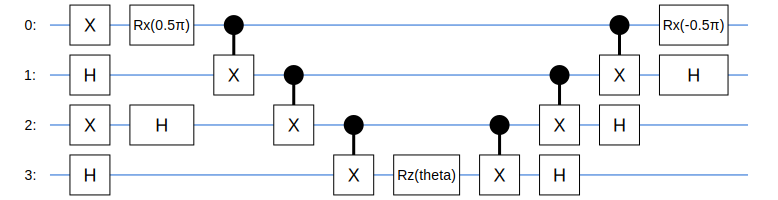

In [5]:
from tangelo.toolboxes.ansatz_generator import RUCC

# One-parameter circuit, and it is set to theta.
ansatz = RUCC(1)
ansatz.set_var_params([theta])
ansatz.build_circuit()

single_entangler_circuit = ansatz.circuit
single_entangler_circuit.draw()

We now perform the symbolic simulation.

In [6]:
hist, statevector = symbolic_backend.simulate(single_entangler_circuit, return_statevector=True)
hist

{'1010': 1.0*cos(theta/2)**2,
 '0101': 1.0*sin(theta/2)**2,
 '1101': 4.93038065763132e-32*sin(theta/2)**2}

As we can see from the results, the probabilities are function of the angle. For any $\theta \in [0, 2\pi]$, only two bitstrings might be measured, preserving the total number of electrons and parity in the circuit. In the next cell, we map the $\text{H}_2$ Hamiltonian to a sum of tensor products of Pauli operators. This operator is then applied onto the single-entangler circuit to get the expectation value, i.e the molecular energy.

In [7]:
from tangelo.molecule_library import mol_H2_sto3g
from tangelo.toolboxes.operators import QubitOperator
from tangelo.toolboxes.qubit_mappings.mapping_transform import fermion_to_qubit_mapping

H = fermion_to_qubit_mapping(mol_H2_sto3g.fermionic_hamiltonian, "JW", 
                             mol_H2_sto3g.n_active_sos, mol_H2_sto3g.n_active_electrons, 
                             up_then_down = True)
energy = symbolic_backend.get_expectation_value(H, single_entangler_circuit)
energy

-0.181288808211496*sin(theta) - 0.78796735887703*cos(theta) - 0.328717028208312

The molecular energy is then a function of $\theta$, plotted below.

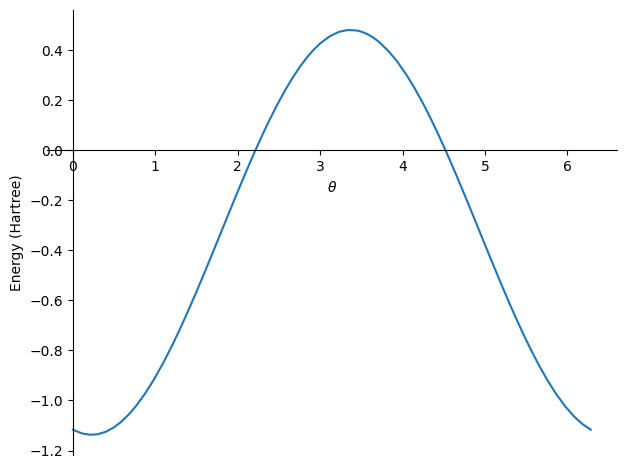

In [8]:
plot(energy, (theta, 0., 2*pi), xlabel=theta, ylabel="Energy (Hartree)")

The energy function is described by a simple peiodic function. As a side note, when the energy exhibits this periodic form, the variational parameter can be optimized anatically using few sampling points with the [Rotosolve algorithm](https://doi.org/10.22331/q-2021-01-28-391).

The minimum energy of this expression is computed in the next cell, and corresponds to the Full-Configuration Interaction (FCI) solution (i.e. the best known ground-state solution).

In [9]:
from sympy.calculus.util import minimum
from sympy.solvers import solve
from tangelo.algorithms.classical import FCISolver

minimum_energy = minimum(energy, theta)
minimum_theta = solve(energy - minimum_energy, theta)[0]

fci = FCISolver(mol_H2_sto3g)
e_fci = fci.simulate()

print(f"Difference between FCI and minimum energy = {abs(e_fci - minimum_energy)} Ha at theta = {minimum_theta:.4f}")

print(f"\nThe histogram at theta = {minimum_theta:.4f}")
for bitstring, prob in hist.items():
  numerical_prob = prob.subs(theta, minimum_theta)
  if numerical_prob > 1e-7:
    print(f"{bitstring}: {numerical_prob:.4f}")

Difference between FCI and minimum energy = 2.22044604925031E-16 Ha at theta = 0.2261

The histogram at theta = 0.2261
1010: 0.9873
0101: 0.0127


### Single shot landscape

This example illustrates the versatility of computing the results as functions of the circuit parameters, and showcases an amplitude amplification circuit.

[Amplitude amplification](https://en.wikipedia.org/wiki/Amplitude_amplification) is a technique that generalizes the idea behind the [Grover's search algorithm](https://arxiv.org/abs/quant-ph/9605043). It is expected to be an important building block for fault-torelant quantum algorithms. Quantum computing is inherently probabilistic, and this technique can improve the statistical occurence of a meaningful state, i.e. increasing its measurement probability. This algorithm has been explained on many platforms: we recommend the Qiskit documentation page on the [Grover’s Algorithm and Amplitude Amplification](https://qiskit.org/documentation/tutorials/algorithms/06_grover.html) for more information.

In the next cell, we first define an empirical state preparation dependent of a parameter $\theta$. The oracle is defined to select the $|11\rangle$ state. Finally, the diffuser circuit is constructed using the known state preparation.

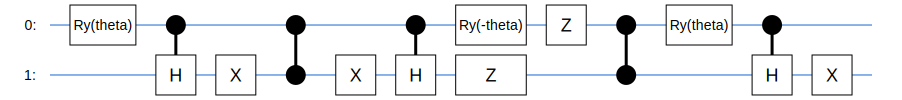

In [10]:
# Circuit taken from: https://qiskit.org/documentation/tutorials/algorithms/06_grover.html

# Empirical state prep: a|01> + b|10> + c|11>
state_prep = Circuit([Gate("RY", 0, parameter=theta), Gate("CH", 1, control=0), Gate("X", 1)])

# Oracle for the |11> state.
oracle_circ = Circuit([Gate("CZ", 1, control=0)])

# Amplitude amplification circuit
diffuser_circ = state_prep.inverse() + Circuit([Gate("Z", 0), Gate("Z", 1), Gate("CZ", 1, control=0)]) + state_prep

amplitude_amp_circuit = state_prep + oracle_circ + diffuser_circ
amplitude_amp_circuit.draw()

Let's get the probability of observing the $|11\rangle$ state with the state preparation circuit.

In [11]:
results_state_prep, _ = symbolic_backend.simulate(state_prep, return_statevector=False)
print("Probability of getting the |11> state after the state preparation:\n")
results_state_prep["11"]

Probability of getting the |11> state after the state preparation:



0.5*sin(theta/2)**2

This probability is proportional to $\sin^2(\theta/2)$. It reaches its maximum value for $\theta = \pi/2$, yielding a probability of $\sin^2(\pi/2)/2 = 0.5$. 

Now, let's repeat these steps for the amplitude amplification component.

In [12]:
results_aa, _ = symbolic_backend.simulate(amplitude_amp_circuit, return_statevector=False)
print("Probability of getting the |11> state after the amplitude amplification:\n")
results_aa["11"]

Probability of getting the |11> state after the amplitude amplification:



0.5*(sin(theta/2)**4 + 9.0*cos(theta/2)**4 - 0.75*cos(2*theta) + 0.75)*sin(theta/2)**2

This probability is still a function of a single variable $\theta$, but it is difficult to visualize it without a graphing tool. Let's plot this expression between $0$ and $2\pi$.

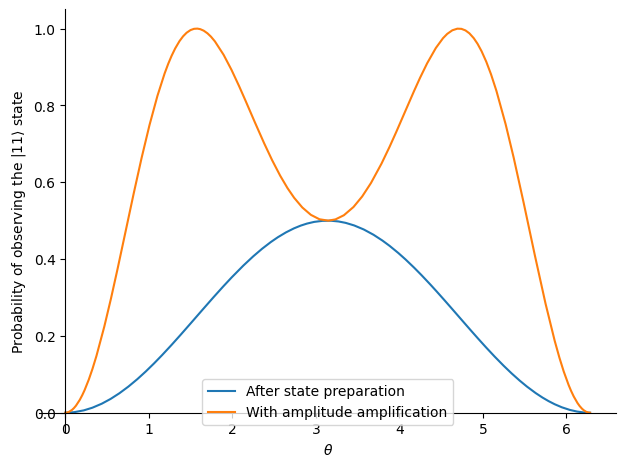

In [13]:
graph = plot(results_state_prep["11"], (theta, 0., 2*pi), xlabel=theta, ylabel=r"Probability of observing the $|11\rangle$ state", label="After state preparation", show=False, legend=True)
graph.extend(plot(results_aa["11"], (theta, 0., 2*pi), label="With amplitude amplification", show=False))
graph.show()

After performing only one simulation, we can draw several conclusions with the amplitude amplification circuit. The probability of getting $|11\rangle$ from the given state preparation has two maxima, one located between $0$ and $\pi$ and the other between $\pi$ and $2\pi$. In those regions, the $|11\rangle$ state is amplified by a significant probability. If $\theta \in \{0, \pi, 2\pi\}$, the amplitude amplification circuit is thus not necessary if one is solely interested in the $|11\rangle$ state.

## Closing words

Using three different use-cases, we illustrated how symbolic simulation can be a powerful tool to propel research in quantum computing. The first one revolves around the compilation of unitaries with different gate sets. In the bigger picture, this could help research on generating quantum circuits from [quantum oracles](https://learn.microsoft.com/en-us/azure/quantum/concepts-oracles). In another example, we discussed the effect of a parametrized rotation gate on the entanglement of a circuit. We shown that the computed energy was described by a periodic function of $\theta$, the parameter controlling the entanglement level between the qubits. The last example introduced the power of single-shot symbolic simulation with the amplitude amplification algorithm. We presented the amplification of $|11\rangle$ on a $a|01\rangle + b|10\rangle + c|11\rangle$ state, where $a,b,c$ are function of $\theta$. 

The main take away of the symbolic simulation concept is the efficiency of simulating many state preparations via a single call to a backend. This is useful in situations where one wish to study entangled qubits, for the design of new circuit primitives, understanding a quantum oracle, or studying the impact of gate parameters on expectation values.